In [1]:
# DA TOGLIERE
import sys
sys.path.append('..')

# Adjoint for integral losses

Distributing the loss in the depth-domain

In [ ]:
### 

In [2]:
from torchdyn.models import *; from torchdyn.data_utils import *
from torchdyn import *

In [3]:
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.functional as F
import pytorch_lightning as pl
import torchdiffeq

In [4]:
from torchdiffeq._impl.misc import _flatten, _flatten_convert_none_to_zeros
from torchdiffeq import odeint

## New Adjoint

### Data

In [5]:
X = torch.tensor([1.,0.])
X = X.repeat(100).reshape(-1,2)
yn = X

X = X + 0.1*torch.randn(X.shape)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
bs = len(X)

X_train = torch.Tensor(X).to(device)
y_train = torch.Tensor(yn).to(device)

train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=bs, shuffle=False)

### Learner

In [7]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, settings:dict={}):
        super().__init__()
        defaults.update(settings)
        self.settings = defaults
        self.model = model
        
    def forward(self, x):
        return self.model(x)    
    
    def training_step(self, batch, batch_idx):
        x, y = batch        
        y_hat = self.model(x)
        loss = nn.MSELoss()(y_hat, y[-1])
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}   
    
    def configure_optimizers(self):
        return torch.optim.RMSprop(self.model.parameters(), lr=0.01)


    def train_dataloader(self):
        return trainloader

## Vanilla Neural ODE (Depth-Invariant)

In [8]:
class Cost(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.y = None
        self.f = f
    def forward(self, s, x):
        self.y = torch.tensor([torch.cos(2*np.pi*s), torch.sin(2*np.pi*s)]).to(device)
        self.y = self.y.repeat(100).reshape(-1,2)
        return self.f(x, self.y)

### Model

In [20]:
settings = {'type':'classic', 'backprop_style':'integral_adjoint', 'controlled':False, 'cost':Cost(nn.MSELoss()),
            'controlled':False, 'return_traj':False, 'solver':'dopri5', 'adjoint':True, 's_end':1,  'atol':1e-6, 'rtol':1e-6}

In [21]:
c = Cost(nn.MSELoss())

In [22]:
func = DEFunc(nn.Sequential(
                      nn.Linear(2,32),
                      nn.Tanh(),
                      nn.Linear(32,32),
                      nn.Tanh(),
                      nn.Linear(32,2)
                                   )
                      )

In [23]:
model = NeuralDE(func, settings).to(device)
learn = Learner(model.to(device))
trainer = pl.Trainer(min_nb_epochs=5000, max_nb_epochs=5000)

In [24]:
model = model.to(device)
trainer.fit(learn)

INFO:lightning:
  | Name             | Type       | Params
--------------------------------------------
0 | model            | NeuralDE   | 1 K   
1 | model.defunc     | DEFunc     | 1 K   
2 | model.defunc.m   | Sequential | 1 K   
3 | model.defunc.m.0 | Linear     | 96    
4 | model.defunc.m.1 | Tanh       | 0     
5 | model.defunc.m.2 | Linear     | 1 K   
6 | model.defunc.m.3 | Tanh       | 0     
7 | model.defunc.m.4 | Linear     | 66    
8 | model.adjoint    | Adjoint    | 0     


INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...


1

### Plot

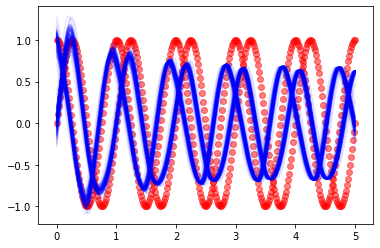

In [27]:
T = torch.linspace(0,5,300)
y1 = np.cos(2*np.pi*T)
y2 = np.sin(2*np.pi*T)
model = model.cpu()
trajectory = model.trajectory(X, T).detach()

settings = {'figsize':(16,4), 'num_flows':100, 'alpha':0.1}
plt.scatter(T, y1, color='red',alpha=0.5)
plt.scatter(T, y2, color='red',alpha=0.5)

T = np.linspace(0,5,300)
for i in range(100):
    plt.plot(T, trajectory[:,i,:], color='blue', alpha=.1)